In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt 
import pandas as pd
import nrrd
import logging
logging.basicConfig(level=logging.INFO)

from dredFISH.Analysis import TissueGraph as tgh
from dredFISH.Analysis import regu
import importlib
importlib.reload(tgh)
importlib.reload(regu)
# from dredFISH.Analysis.TissueGraph import *
# from dredFISH.Visualization.Viz import *


<module 'dredFISH.Analysis.regu' from '/bigstore/GeneralStorage/fangming/projects/dredfish/packages/dredFISH/dredFISH/Analysis/regu.py'>

In [2]:
### file paths
## inputs
# allen data
allen_template_path='/bigstore/binfo/mouse/Brain/average_template.npy'
allen_tree_path='/bigstore/GeneralStorage/fangming/reference/allen_ccf/structures.json'
allen_annot_path='/bigstore/GeneralStorage/fangming/reference/allen_ccf/annotation_10.nrrd'

# dredFISH data
dataset = 'DPNMF_PolyA_2021Nov19' # dataset tag
base_path = '/bigstore/Images2021/gaby/dredFISH/DPNMF_PolyA_2021Nov19/'
fish_path = f'{base_path}fishdata_2022Mar23/' # Zach's new version
anndata_path = f'{base_path}results/raw_fishdata_Mar30.h5ad'

## output
version = 'v2'
outdir = '/bigstore/GeneralStorage/fangming/projects/dredfish/data_dump/'
out_spatial_prefix = f"{outdir}{dataset}_{version}_spatialreg_"
out_anndata = f"{outdir}{dataset}_{version}_results_anndata.h5ad"
out_tmg = f"{outdir}{dataset}_{version}_results_tmg.pkl"

# check output filenames
logging.info(out_spatial_prefix)
logging.info(out_anndata)
logging.info(out_tmg)

INFO:root:/bigstore/GeneralStorage/fangming/projects/dredfish/data_dump/DPNMF_PolyA_2021Nov19_v2_spatialreg_
INFO:root:/bigstore/GeneralStorage/fangming/projects/dredfish/data_dump/DPNMF_PolyA_2021Nov19_v2_results_anndata.h5ad
INFO:root:/bigstore/GeneralStorage/fangming/projects/dredfish/data_dump/DPNMF_PolyA_2021Nov19_v2_results_tmg.pkl


## Load data

In [3]:
%%time
# load Allen reference
allen_template = regu.load_allen_template(allen_template_path)
allen_tree, allen_maps = regu.load_allen_tree(allen_tree_path)
allen_annot = regu.load_allen_annot(allen_annot_path) # takes about 30 seconds

CPU times: user 15.7 s, sys: 16.5 s, total: 32.2 s
Wall time: 34 s


In [4]:
%%time
# load dredFISH
TMG = tgh.TissueMultiGraph(name=dataset)
# load raw counts data
if os.path.isfile(anndata_path):
    print('from AnnData')
    TMG.load_from_anndata(anndata_path)
else:
    print('from FishData')
    TMG.load_from_fishdata(fish_path, dataset, output_path=anndata_path)
    
# # normalize (optional for spatial registration)
# TMG.normalize_data(norm_cell=True, norm_bit=True)

TypeError: TissueMultiGraph.__init__() got an unexpected keyword argument 'name'

In [5]:
TMG.data.obs

NameError: name 'TMG' is not defined

# Spatial registration thru TMG

In [ ]:
%%time
idx_ccf = 720 
flip = False
# nothing will be saved. Just a preview to test parameters
spatial_data = TMG.spatial_registration_preview(
    allen_template, allen_annot, allen_maps, # allen references
    idx_ccf, # index of the matched 2d section (anterior->posterior) try it out here (0~1319)
    flip=flip,
    )

INFO:root:To generate: /bigstore/GeneralStorage/fangming/projects/dredfish/data_dump/DPNMF_PolyA_2021Nov19_v2_spatialreg_affine_
 /bigstore/GeneralStorage/fangming/projects/dredfish/data_dump/DPNMF_PolyA_2021Nov19_v2_spatialreg_syn_
 /bigstore/GeneralStorage/fangming/projects/dredfish/data_dump/DPNMF_PolyA_2021Nov19_v2_spatialreg_registered.hdf5


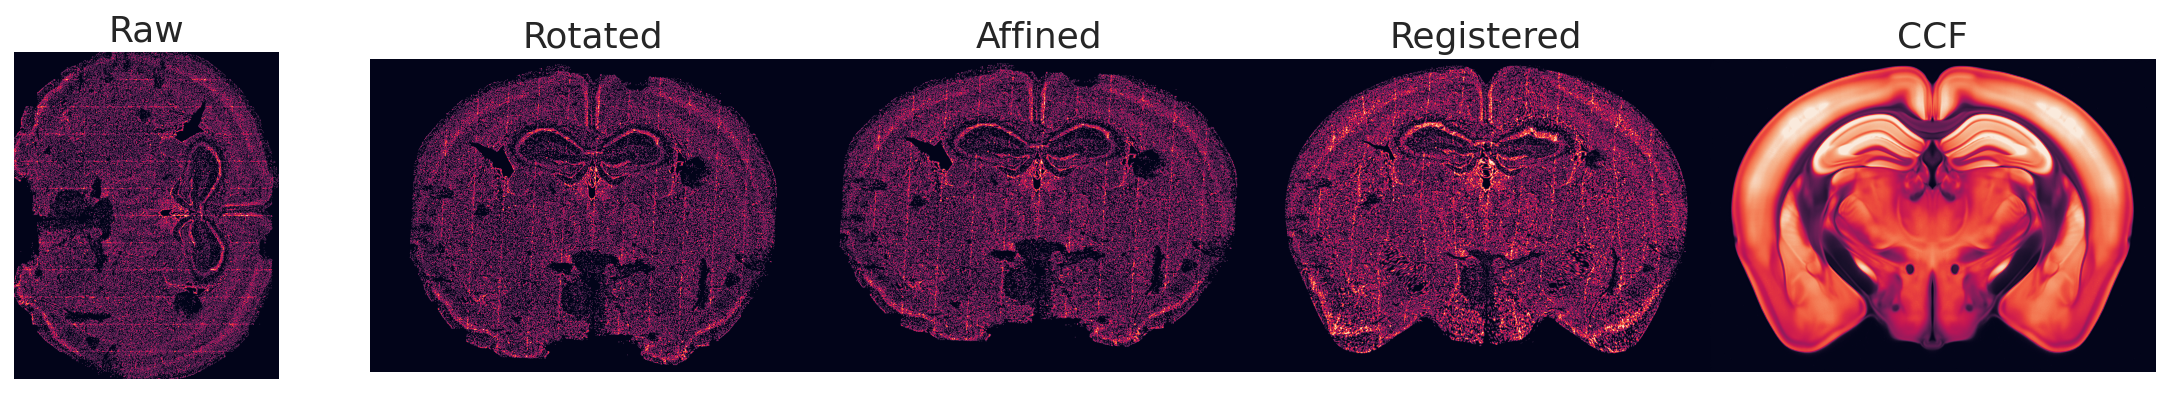

Trying to set attribute `.obs` of view, copying.


saved to /bigstore/GeneralStorage/fangming/projects/dredfish/data_dump/DPNMF_PolyA_2021Nov19_v2_spatialreg_registered.hdf5
CPU times: user 2min 10s, sys: 27.7 s, total: 2min 37s
Wall time: 14.7 s


In [10]:
%%time
idx_ccf = 720
flip = False
# this will save spatial transformations and results to files `out_spatial_prefix`
# this will also adds the following new columns to TMG.data.obs: 
# `region_id` `region_color` `region_acronym` `coord_x` `coord_y`
spatial_data = TMG.spatial_registration(
                            allen_template, allen_annot, allen_maps,
                            idx_ccf,
                            flip=flip,
                            outprefix=out_spatial_prefix,
                            force=False,
                            )

In [11]:
# the new columns
TMG.data.obs[['region_id', 'region_color', 'region_acronym', 'coord_x', 'coord_y']]

region_id region_color  \
DPNMF_PolyA_2021Nov19_Pos98_cell_1.0            574      #98D6F9   
DPNMF_PolyA_2021Nov19_Pos98_cell_2.0           1202      #CCCCCC   
DPNMF_PolyA_2021Nov19_Pos98_cell_3.0           1218      #CCCCCC   
DPNMF_PolyA_2021Nov19_Pos98_cell_4.0           1218      #CCCCCC   
DPNMF_PolyA_2021Nov19_Pos98_cell_5.0           1218      #CCCCCC   
...                                             ...          ...   
DPNMF_PolyA_2021Nov19_Pos102_cell_1357.0       1200      #CCCCCC   
DPNMF_PolyA_2021Nov19_Pos102_cell_1358.0        463      #7ED04B   
DPNMF_PolyA_2021Nov19_Pos102_cell_1359.0       1200      #CCCCCC   
DPNMF_PolyA_2021Nov19_Pos102_cell_1360.0       1200      #CCCCCC   
DPNMF_PolyA_2021Nov19_Pos102_cell_1362.0       1200      #CCCCCC   

                                         region_acronym      coord_x  \
DPNMF_PolyA_2021Nov19_Pos98_cell_1.0                 CP  3066.632792   
DPNMF_PolyA_2021Nov19_Pos98_cell_2.0                int  3013.860099   
DPNMF_PolyA_2021Nov19_Pos98_cell_3.0                 ar  2835.027489   
DPNMF_PolyA_2021Nov19_Pos98_cell_4.0                 ar  2784.899438   
DPNMF_PolyA_2021Nov19_Pos98_cell_5.0                 ar  2773.655749   
...                                                 ...          ...   
DPNMF_PolyA_2021Nov19_Pos102_cell_1357.0            ccs  2962.233204   
DPNMF_PolyA_2021Nov19_Pos102_cell_1358.0            CA2  2790.109448   
DPNMF_PolyA_2021Nov19_Pos102_cell_1359.0            ccs  2977.062698   
DPNMF_PolyA_2021Nov19_Pos102_cell_1360.0            ccs  2999.081110   
DPNMF_PolyA_2021Nov19_Pos102_cell_1362.0            ccs  3009.308977   

                                              coord_y  
DPNMF_PolyA_2021Nov19_Pos98_cell_1.0       582.574703  
DPNMF_PolyA_2021Nov19_Pos98_cell_2.0       578.800986  
DPNMF_PolyA_2021Nov19_Pos98_cell_3.0       571.977073  
DPNMF_PolyA_2021Nov19_Pos98_cell_4.0       570.399427  
DPNMF_PolyA_2021Nov19_Pos98_cell_5.0       566.644009  
...                                               ...  
DPNMF_PolyA_2021Nov19_Pos102_cell_1357.0 -1423.737878  
DPNMF_PolyA_2021Nov19_Pos102_cell_1358.0 -1432.947971  
DPNMF_PolyA_2021Nov19_Pos102_cell_1359.0 -1422.840896  
DPNMF_PolyA_2021Nov19_Pos102_cell_1360.0 -1420.642344  
DPNMF_PolyA_2021Nov19_Pos102_cell_1362.0 -1420.004760  

[113758 rows x 5 columns]

In [12]:
# check results -- plot all cells
def plot_spatial(TMG):
    """
    """
    fig, ax = plt.subplots(1, 1, figsize=(8,6))
    ax.scatter(TMG.data.obs['coord_x'], 
               TMG.data.obs['coord_y'],
               c=TMG.data.obs['region_color'],
               s=0.05,
               rasterized=True,
              )
    ax.invert_yaxis()
    ax.set_aspect('equal')
    ax.set_title('Cells colored by brain regions (moved ABA)')
    ax.axis('off')
    plt.show()

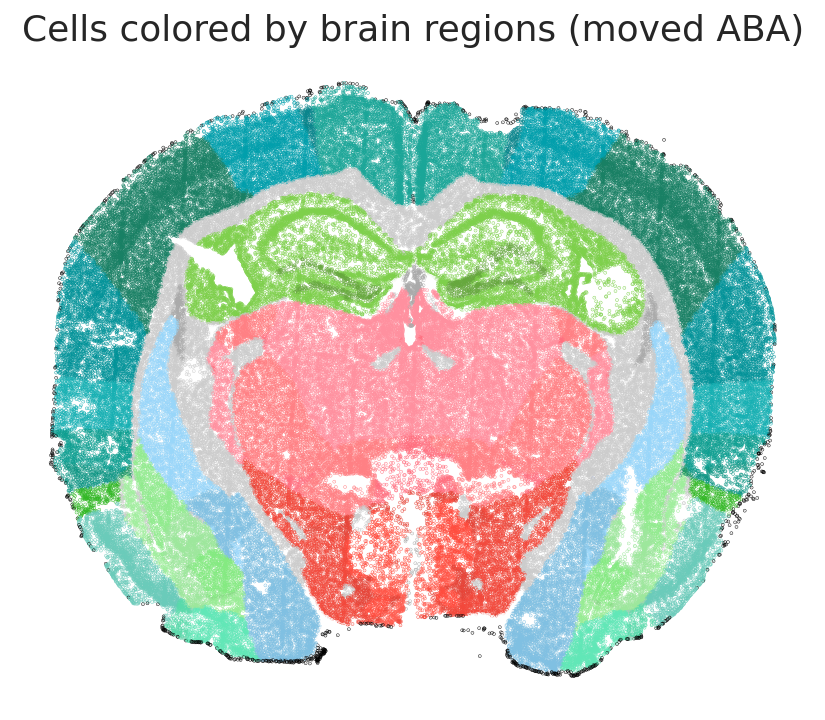

In [13]:
plot_spatial(TMG)

In [14]:
%%time
# save results
TMG.save_anndata(out_anndata)
TMG.save(out_tmg)

/home/fangming/anaconda3/envs/routine/lib/python3.10/site-packages/anndata/_core/anndata.py:1228: FutureWarning:

The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.

... storing 'region_color' as categorical
/home/fangming/anaconda3/envs/routine/lib/python3.10/site-packages/anndata/_core/anndata.py:1228: FutureWarning:

The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.

... storing 'region_acronym' as categorical
INFO:root:saved to /bigstore/GeneralStorage/fangming/projects/dredfish/data_dump/DPNMF_PolyA_2021Nov19_v2_results_anndata.h5ad
INFO:root:saved to /bigstore/GeneralStorage/fangming/projects/dredfish/data_dump/DPNMF_PolyA_2021Nov19_v2_results_tmg.pkl


CPU times: user 1.45 s, sys: 254 ms, total: 1.7 s
Wall time: 2.18 s


# check saved results

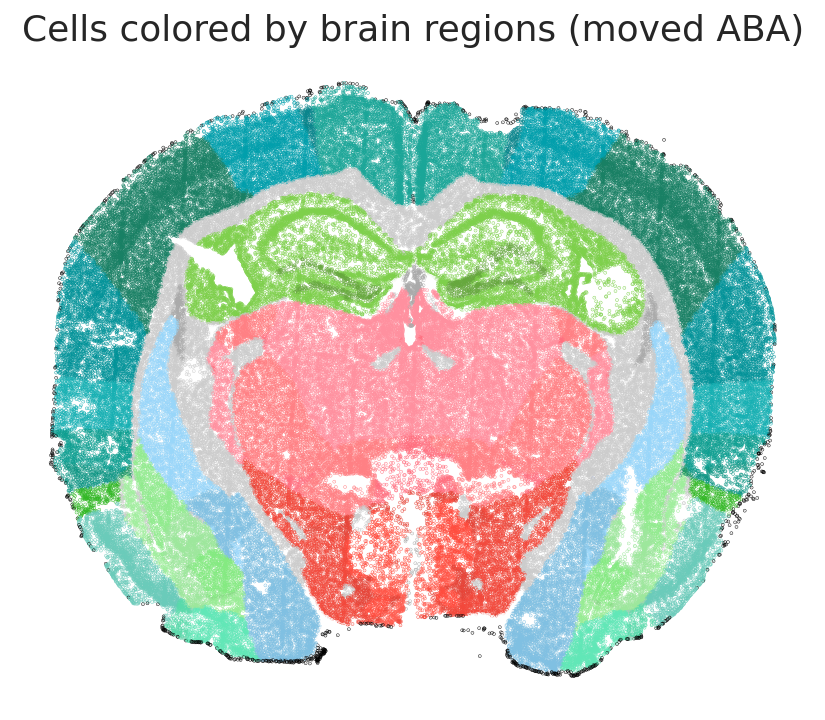

CPU times: user 2.12 s, sys: 75.8 ms, total: 2.2 s
Wall time: 2.25 s


In [15]:
%%time
TMG2 = tgh.TissueMultiGraph(name=dataset, fullfilename=out_tmg)
plot_spatial(TMG2)

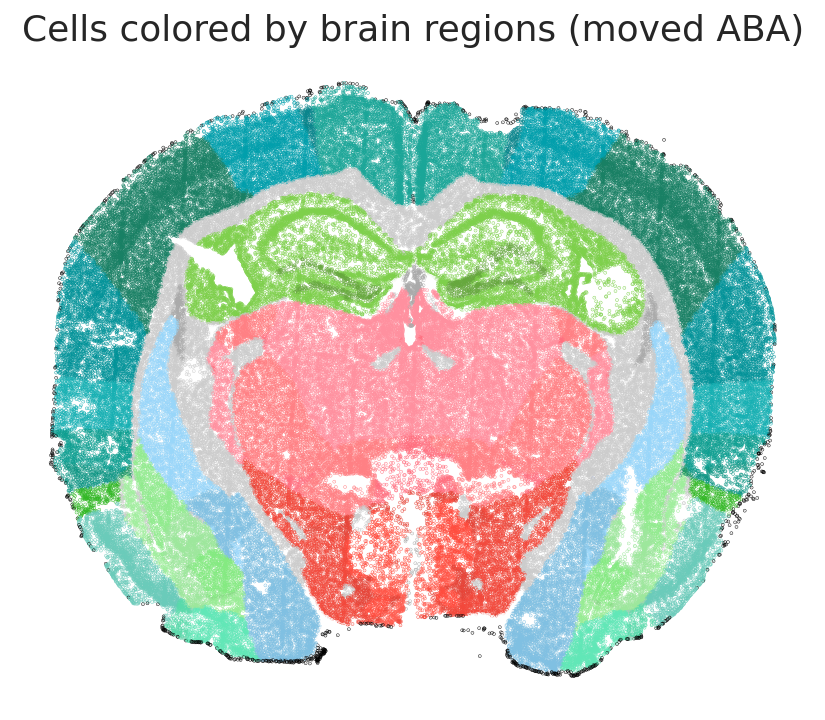

CPU times: user 2.32 s, sys: 127 ms, total: 2.45 s
Wall time: 2.41 s


In [16]:
%%time
TMG3 = tgh.TissueMultiGraph(name=dataset)
TMG3.load_from_anndata(out_anndata)
plot_spatial(TMG3)